In [184]:
import pandas as pd
import numpy as np
from functools import reduce

# xgb boost
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# causal forest 
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm


In [185]:
des_data = pd.read_stata(r"C:\Users\timom\OneDrive\Desktop\ML\OHIE_Public_Use_Files\OHIE_Data\oregonhie_descriptive_vars.dta")
ed_data = pd.read_stata(r"C:\Users\timom\OneDrive\Desktop\ML\OHIE_Public_Use_Files\OHIE_Data\oregonhie_ed_vars.dta")
inperson_data = pd.read_stata(r"C:\Users\timom\OneDrive\Desktop\ML\OHIE_Public_Use_Files\OHIE_Data\oregonhie_inperson_vars.dta")
stateprograms_data = pd.read_stata(r"C:\Users\timom\OneDrive\Desktop\ML\OHIE_Public_Use_Files\OHIE_Data\oregonhie_stateprograms_vars.dta")
survey0_data = pd.read_stata(r"C:\Users\timom\OneDrive\Desktop\ML\OHIE_Public_Use_Files\OHIE_Data\oregonhie_survey0m_vars.dta")
survey12_data = pd.read_stata(r"C:\Users\timom\OneDrive\Desktop\ML\OHIE_Public_Use_Files\OHIE_Data\oregonhie_survey12m_vars.dta")

In [186]:
des_data_copy = des_data.copy()
ed_data_copy = ed_data.copy()
inperson_data_copy = inperson_data.copy()
stateprograms_data_copy = stateprograms_data.copy()
survey0_data_copy = survey0_data.copy()
survey12_data_copy = survey12_data.copy()

In [187]:
# check = [des_data, stateprograms_data, ed_data, inperson_data, patterns_data, survey0_data, survey12_data]
# non_binary_category_columns = []
# for df in check:
#     a = [col for col in df.columns if pd.api.types.is_categorical_dtype(df[col]) and df[col].nunique(dropna=True) > 2]
#     non_binary_category_columns += a
# non_binary_category_columns = np.unique(non_binary_category_columns)
# non_binary_category_columns


## Creating Data for XGBoost

In [188]:
#Descriptive 
des_data = des_data.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
des_data['applied_app'].replace(-1, 0, inplace=True)
des_data['approved_app'].replace(-1, 0, inplace=True)
des_data['OHIE_app_ins'] = des_data['treatment'] * des_data['applied_app'] * des_data['approved_app']
des_data.replace(-1, np.nan, inplace=True)

In [189]:
# State
stateprograms_data = stateprograms_data.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
stateprograms_data.replace(-1, np.nan, inplace=True)

In [190]:
# Ed
ed_data = ed_data.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
ed_data.replace(-1, np.nan, inplace=True)

In [191]:
# In Person
inperson_data = inperson_data.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
inperson_data.replace(-1, np.nan, inplace=True)

In [192]:
# Survey 0
survey0_data = survey0_data.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
survey0_data.replace(-1, np.nan, inplace=True)

In [193]:
# Survey 12
survey12_data = survey12_data.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
survey12_data.replace(-1, np.nan, inplace=True)

In [194]:
# merge data
dfs = [des_data, stateprograms_data, ed_data, inperson_data, survey0_data, survey12_data]
merged = reduce(lambda left, right: pd.merge(left, right, on='person_id', how='outer'), dfs)

In [195]:
# format the data correctly
df_filtered = merged.filter(regex='^(?!.*_y$)')
df_filtered = df_filtered.rename(lambda x: x.replace('_x', ''), axis=1)
df_filtered = df_filtered.apply(lambda x: pd.to_numeric(x, errors='coerce') if x.dtype == 'object' else x)
datetime_columns = df_filtered.select_dtypes('datetime64[ns]').columns
ordinal_encoder = OrdinalEncoder()
df_filtered[datetime_columns] = ordinal_encoder.fit_transform(df_filtered[datetime_columns])
# subset to survey respondents 
df_filtered = df_filtered[df_filtered['returned_12m']==1]


In [196]:
# create outcomes 
df_filtered.loc[:,'dep_score'] = df_filtered.loc[:,'dep_interest_12m'] + df_filtered.loc[:,'dep_sad_12m']
df_filtered.loc[:,'dep_indc'] = df_filtered.loc[:,'dep_score'] >= 3.0
df_filtered.loc[:,'neg_dep_indc'] = - df_filtered.loc[:,'dep_indc'] 
df_filtered.loc[:,'neg_health_gen_bin_12m'] = 1 - df_filtered.loc[:,'health_gen_bin_12m']
df_filtered.loc[:,'neg_health_chg_bin_12m'] = 1 - df_filtered.loc[:,'health_chg_bin_12m']
df_filtered.loc[:,'gooddays_phys_12m'] = 30 - df_filtered.loc[:,'baddays_phys_12m']
df_filtered.loc[:,'gooddays_ment_12m'] = 30 - df_filtered.loc[:,'baddays_ment_12m']
df_filtered.loc[:,'neg_health_work_12m'] = 1 - df_filtered.loc[:,'health_work_12m']

df_filtered.loc[:,'ner_noner_12m'] = 1 - df_filtered.loc[:,'er_noner_12m']

In [197]:
# define outcomes   


outcome1 = ['rx_any_12m', 'rx_num_mod_12m', 'doc_any_12m', 'doc_num_mod_12m', 
             'er_any_12m', 'er_num_mod_12m', 'hosp_any_12m' , 'hosp_num_mod_12m']

outcome2 = ['cost_any_oop_12m', 'cost_any_owe_12m', 'cost_borrow_12m', 'cost_refused_12m'] 

# 'cost_tot_oop_12m''cost_tot_owe_12m', 

outcome3 = ['neg_health_gen_bin_12m', 'neg_health_chg_bin_12m', 'gooddays_phys_12m','gooddays_ment_12m',
            'neg_health_work_12m', 'neg_dep_indc'] 

outcome4 = ['usual_clinic_12m', 'usual_doc_12m', 'needmet_med_12m', 'needmet_rx_12m', 
            'ner_noner_12m', 'med_qual_bin_12m', 'happiness_12m'] 

outcomes = outcome1 + outcome2 + outcome3 + outcome4

In [198]:
filtered_columns = df_filtered.filter(regex='(pre_ed$|pre_cens_ed$|pre_lottery_inp$|pre|0m$)').columns.tolist() + ['person_id','household_id', 'ohp_all_ever_matchn_30sep2009',
                                                                                                                   'edu_inp', 'hispanic_inp', 
                                                                                                                   'race_white_inp', 'race_black_inp', 
                                                                                                                   'race_nwother_inp', 'cvd_risk_point_inp',
                                                                                                                   'smk_curr_inp'] + list(des_data.columns) + list(survey0_data.columns) + list(survey12_data.columns) + outcomes
df_filtered = df_filtered[np.unique(filtered_columns)]

In [199]:
# drop columns that have more than 50% NA values, choose 50 as to not filter out any outcomes,
# but als limit weak covariates confounders
threshold = 0.5 * len(df_filtered)

# Drop columns with more than 50% NA values
df_filtered = df_filtered.dropna(axis=1, thresh=threshold)


remove  = list(df_filtered.columns.intersection(survey12_data.columns))


In [200]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23777 entries, 0 to 74920
Columns: 234 entries, OHIE_app_ins to zip_msa_list
dtypes: bool(1), float32(21), float64(187), int16(2), int8(23)
memory usage: 36.6 MB


## PART 1 Feature Selection
In this part we reduce the dimmensionality of the data

I will test different feature importance selection schemes to see which ones are best. 

In [201]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23777 entries, 0 to 74920
Columns: 234 entries, OHIE_app_ins to zip_msa_list
dtypes: bool(1), float32(21), float64(187), int16(2), int8(23)
memory usage: 36.6 MB


In [202]:
df_filtered[outcomes].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23777 entries, 0 to 74920
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   rx_any_12m              18332 non-null  float64
 1   rx_num_mod_12m          18321 non-null  float64
 2   doc_any_12m             23528 non-null  float64
 3   doc_num_mod_12m         23477 non-null  float64
 4   er_any_12m              23550 non-null  float64
 5   er_num_mod_12m          23517 non-null  float64
 6   hosp_any_12m            23609 non-null  float64
 7   hosp_num_mod_12m        23575 non-null  float64
 8   cost_any_oop_12m        23462 non-null  float64
 9   cost_any_owe_12m        23487 non-null  float64
 10  cost_borrow_12m         23446 non-null  float64
 11  cost_refused_12m        22605 non-null  float64
 12  neg_health_gen_bin_12m  23397 non-null  float64
 13  neg_health_chg_bin_12m  23443 non-null  float64
 14  gooddays_phys_12m       21415 non-null

In [203]:
missing_percentage = df_filtered[outcomes].isnull().mean() * 100

sorted_columns = missing_percentage.sort_values(ascending=False)

sorted_columns.head(40)

med_qual_bin_12m          31.294949
rx_num_mod_12m            22.946545
rx_any_12m                22.900282
gooddays_phys_12m          9.933970
usual_clinic_12m           9.252639
gooddays_ment_12m          9.021323
cost_refused_12m           4.929133
needmet_rx_12m             3.856668
needmet_med_12m            3.520209
neg_health_work_12m        1.753796
neg_health_gen_bin_12m     1.598183
neg_health_chg_bin_12m     1.404719
cost_borrow_12m            1.392102
happiness_12m              1.375279
cost_any_oop_12m           1.324810
doc_num_mod_12m            1.261724
cost_any_owe_12m           1.219666
er_num_mod_12m             1.093494
doc_any_12m                1.047231
usual_doc_12m              1.009379
er_any_12m                 0.954704
ner_noner_12m              0.887412
hosp_num_mod_12m           0.849560
hosp_any_12m               0.706565
neg_dep_indc               0.000000
dtype: float64

### Outcome 1

In [204]:
df = df_filtered.dropna(subset= outcome1)
X1 = df.drop(columns= ['person_id','household_id', 'ohp_all_ever_matchn_30sep2009','birthyear_0m'] + remove + outcomes)  
y1 = df[outcome1]

In [205]:
model1 = xgb.XGBRegressor(objective='reg:squarederror')
model1.fit(X1, y1)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

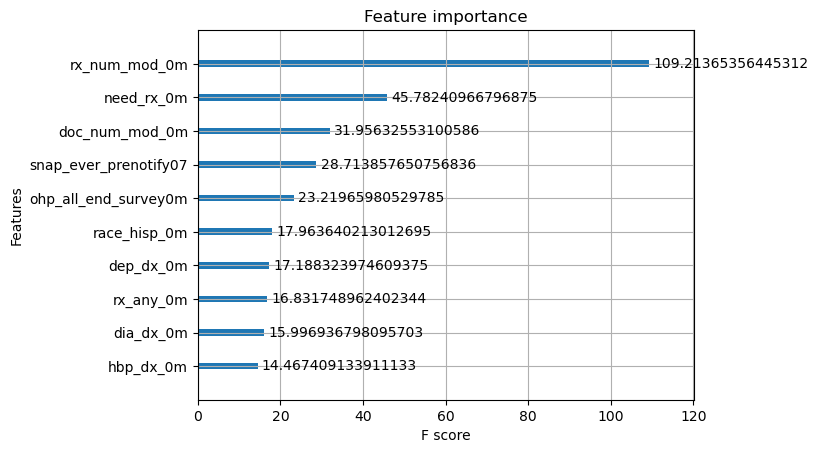

In [206]:
xgb.plot_importance(model1,max_num_features=10, importance_type='gain')

In [207]:
feat1 = model1.get_booster().get_score(importance_type='gain')
feat1 = dict(sorted(feat1.items(), key=lambda item: item[1], reverse=True))
values1 = list(feat1.values())
thresh1 = np.percentile(values1,75)
feat1 = [key for key, value in feat1.items() if value > thresh1]
thresh1

8.34741735458374

In [208]:
feat1

['rx_num_mod_0m',
 'need_rx_0m',
 'doc_num_mod_0m',
 'snap_ever_prenotify07',
 'ohp_all_end_survey0m',
 'race_hisp_0m',
 'dep_dx_0m',
 'rx_any_0m',
 'dia_dx_0m',
 'hbp_dx_0m',
 'english_list',
 'ins_noins_0m',
 'ins_othcov_0m',
 'ohp_all_mo_firstn_survey0m',
 'er_num_mod_0m',
 'health_chg_0m',
 'need_med_0m',
 'birthyear_list',
 'female_list',
 'ins_medicare_0m',
 'er_noner_0m',
 'er_any_0m',
 'emp_dx_0m',
 'tanf_ever_presurvey12m']

### Outcome 2

In [209]:
df = df_filtered.dropna(subset= outcome2)
X2 = df.drop(columns= ['person_id','household_id', 'ohp_all_ever_matchn_30sep2009','birthyear_0m'] + remove + outcomes)  
y2 = df[outcome2]

In [210]:
model2 = xgb.XGBRegressor(objective='reg:squarederror')
model2.fit(X2, y2)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

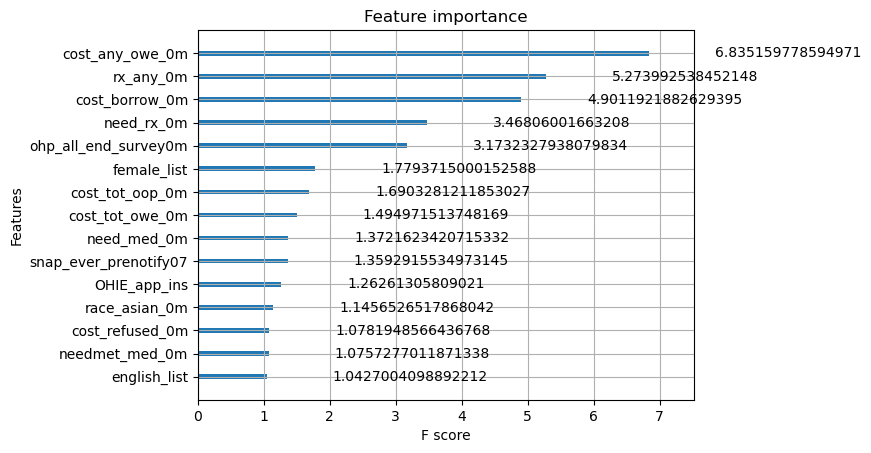

In [211]:
xgb.plot_importance(model2,max_num_features=15, importance_type='gain')

In [212]:
feat2 = model2.get_booster().get_score(importance_type='gain')
feat2 = dict(sorted(feat2.items(), key=lambda item: item[1], reverse=True))
values2 = list(feat2.values())
thresh2 = np.percentile(values2,75)
feat2 = [key for key, value in feat2.items() if value > thresh2]
thresh2

0.7664383947849274

In [213]:
feat2

['cost_any_owe_0m',
 'rx_any_0m',
 'cost_borrow_0m',
 'need_rx_0m',
 'ohp_all_end_survey0m',
 'female_list',
 'cost_tot_oop_0m',
 'cost_tot_owe_0m',
 'need_med_0m',
 'snap_ever_prenotify07',
 'OHIE_app_ins',
 'race_asian_0m',
 'cost_refused_0m',
 'needmet_med_0m',
 'english_list',
 'rx_num_mod_0m',
 'dep_dx_0m',
 'usual_clinic_0m',
 'usual_place_0m',
 'ohp_all_ever_firstn_survey0m',
 'ins_employer_0m',
 'needmet_rx_0m',
 'cost_rx_oop_0m',
 'self_list']

### Outcome 3

In [214]:
df = df_filtered.dropna(subset= outcome3)
X3 = df.drop(columns= ['person_id','household_id', 'ohp_all_ever_matchn_30sep2009','birthyear_0m'] + remove + outcomes)  
y3 = df[outcome3]

In [215]:
model3 = xgb.XGBRegressor(objective='reg:squarederror')
model3.fit(X3, y3)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

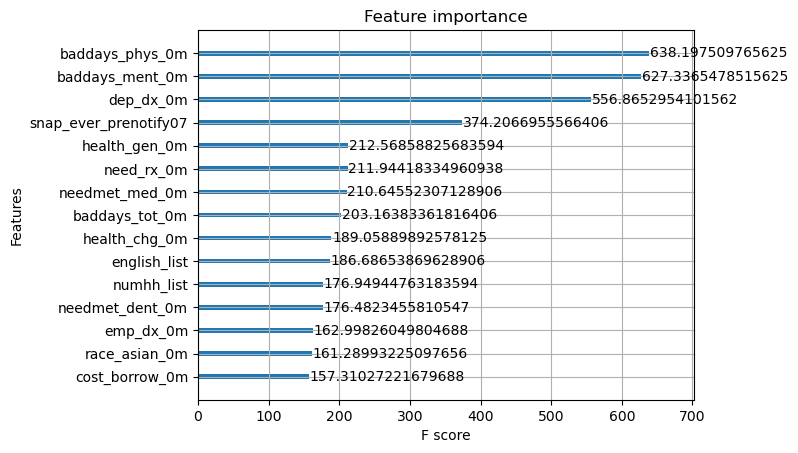

In [216]:
xgb.plot_importance(model3,max_num_features=15, importance_type='gain')

In [217]:
feat3 = model3.get_booster().get_score(importance_type='gain')
feat3 = dict(sorted(feat3.items(), key=lambda item: item[1], reverse=True))
values3 = list(feat3.values())
thresh3 = np.percentile(values3,75)
feat3 = [key for key, value in feat3.items() if value > thresh3]
thresh3

130.28409576416016

In [218]:
feat3

['baddays_phys_0m',
 'baddays_ment_0m',
 'dep_dx_0m',
 'snap_ever_prenotify07',
 'health_gen_0m',
 'need_rx_0m',
 'needmet_med_0m',
 'baddays_tot_0m',
 'health_chg_0m',
 'english_list',
 'numhh_list',
 'needmet_dent_0m',
 'emp_dx_0m',
 'race_asian_0m',
 'cost_borrow_0m',
 'er_num_mod_0m',
 'birthyear_list',
 'employ_hrs_0m',
 'needmet_rx_0m',
 'ohp_all_mo_firstn_survey0m',
 'need_med_0m',
 'ins_privpay_0m',
 'snap_tot_hh_presurvey12m',
 'race_white_0m']

### Outcome 4

In [219]:
df = df_filtered.dropna(subset= outcome4)
X4 = df.drop(columns= ['person_id','household_id', 'ohp_all_ever_matchn_30sep2009','birthyear_0m'] + remove + outcomes)  
y4 = df[outcome4]

In [220]:
model4 = xgb.XGBRegressor(objective='reg:squarederror')
model4.fit(X4, y4)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

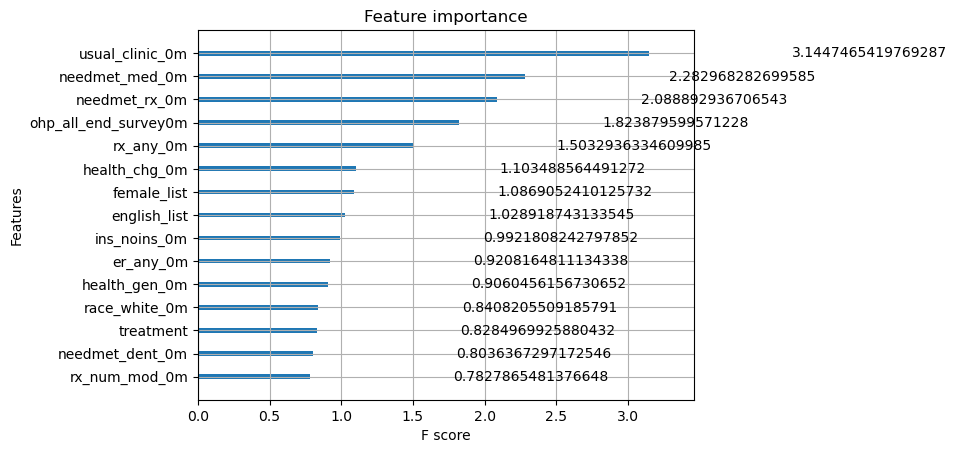

In [221]:
xgb.plot_importance(model4,max_num_features=15, importance_type='gain')

In [222]:
feat4 = model4.get_booster().get_score(importance_type='gain')
feat4 = dict(sorted(feat4.items(), key=lambda item: item[1], reverse=True))
values4 = list(feat4.values())
thresh4 = np.percentile(values4,75)
feat4 = [key for key, value in feat4.items() if value > thresh4]
thresh4

0.7309662997722626

In [223]:
feat4

['usual_clinic_0m',
 'needmet_med_0m',
 'needmet_rx_0m',
 'ohp_all_end_survey0m',
 'rx_any_0m',
 'health_chg_0m',
 'female_list',
 'english_list',
 'ins_noins_0m',
 'er_any_0m',
 'health_gen_0m',
 'race_white_0m',
 'treatment',
 'needmet_dent_0m',
 'rx_num_mod_0m',
 'baddays_ment_0m',
 'needmet_qn_med_0m',
 'snap_ever_presurvey12m',
 'snap_ever_prenotify07',
 'tanf_ever_presurvey12m',
 'ins_ohp_0m',
 'ohp_all_ever_firstn_survey0m',
 'dep_dx_0m',
 'ins_months_0m']

In [224]:
# Select top features, for each model took top 90th percentile of gain 
top_feat = np.unique(feat1 + feat2 + feat3+ feat4)
top_feat = list(top_feat)
top_feat

['OHIE_app_ins',
 'baddays_ment_0m',
 'baddays_phys_0m',
 'baddays_tot_0m',
 'birthyear_list',
 'cost_any_owe_0m',
 'cost_borrow_0m',
 'cost_refused_0m',
 'cost_rx_oop_0m',
 'cost_tot_oop_0m',
 'cost_tot_owe_0m',
 'dep_dx_0m',
 'dia_dx_0m',
 'doc_num_mod_0m',
 'emp_dx_0m',
 'employ_hrs_0m',
 'english_list',
 'er_any_0m',
 'er_noner_0m',
 'er_num_mod_0m',
 'female_list',
 'hbp_dx_0m',
 'health_chg_0m',
 'health_gen_0m',
 'ins_employer_0m',
 'ins_medicare_0m',
 'ins_months_0m',
 'ins_noins_0m',
 'ins_ohp_0m',
 'ins_othcov_0m',
 'ins_privpay_0m',
 'need_med_0m',
 'need_rx_0m',
 'needmet_dent_0m',
 'needmet_med_0m',
 'needmet_qn_med_0m',
 'needmet_rx_0m',
 'numhh_list',
 'ohp_all_end_survey0m',
 'ohp_all_ever_firstn_survey0m',
 'ohp_all_mo_firstn_survey0m',
 'race_asian_0m',
 'race_hisp_0m',
 'race_white_0m',
 'rx_any_0m',
 'rx_num_mod_0m',
 'self_list',
 'snap_ever_prenotify07',
 'snap_ever_presurvey12m',
 'snap_tot_hh_presurvey12m',
 'tanf_ever_presurvey12m',
 'treatment',
 'usual_clinic

In [225]:
missing_percentage = df_filtered[top_feat].isnull().mean() * 100

sorted_columns = missing_percentage.sort_values(ascending = False)

sorted_columns.head(30)

needmet_qn_med_0m    47.848761
cost_rx_oop_0m       41.140598
cost_tot_owe_0m      40.131219
ins_ohp_0m           36.619422
baddays_phys_0m      36.468015
baddays_ment_0m      36.446987
baddays_tot_0m       36.055852
cost_tot_oop_0m      35.803508
rx_num_mod_0m        35.534340
rx_any_0m            35.500694
usual_clinic_0m      34.945536
cost_refused_0m      33.578668
needmet_med_0m       33.490348
needmet_rx_0m        32.653405
needmet_dent_0m      32.426294
health_gen_0m        32.308533
er_noner_0m          31.879547
health_chg_0m        31.593557
usual_place_0m       31.328595
cost_borrow_0m       31.248686
ins_months_0m        31.198217
race_hisp_0m         31.151954
employ_hrs_0m        31.118308
er_num_mod_0m        30.920638
doc_num_mod_0m       30.882786
need_rx_0m           30.865963
er_any_0m            30.849140
need_med_0m          30.849140
cost_any_owe_0m      30.840728
race_white_0m        30.289776
dtype: float64

## KNN

In [226]:
df_data = df_filtered[['person_id','household_id', 'ohp_all_ever_matchn_30sep2009'] + outcomes + top_feat]

In [227]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23777 entries, 0 to 74920
Data columns (total 82 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   person_id                      23777 non-null  float32
 1   household_id                   23777 non-null  float32
 2   ohp_all_ever_matchn_30sep2009  23777 non-null  int8   
 3   rx_any_12m                     18332 non-null  float64
 4   rx_num_mod_12m                 18321 non-null  float64
 5   doc_any_12m                    23528 non-null  float64
 6   doc_num_mod_12m                23477 non-null  float64
 7   er_any_12m                     23550 non-null  float64
 8   er_num_mod_12m                 23517 non-null  float64
 9   hosp_any_12m                   23609 non-null  float64
 10  hosp_num_mod_12m               23575 non-null  float64
 11  cost_any_oop_12m               23462 non-null  float64
 12  cost_any_owe_12m               23487 non-null 

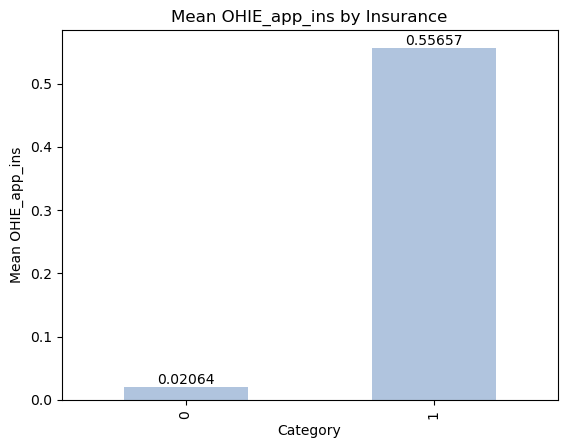

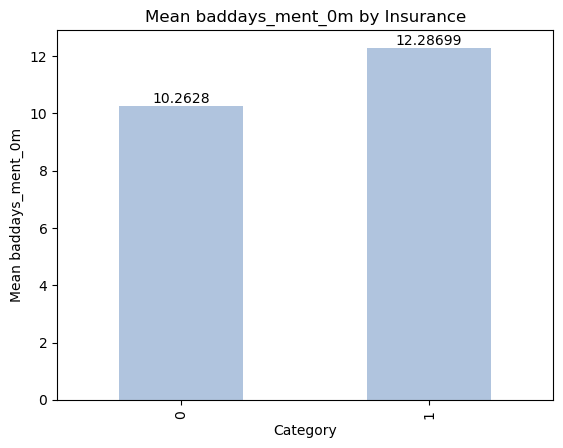

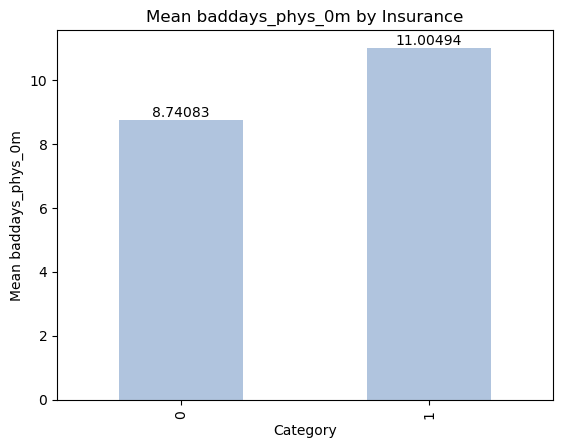

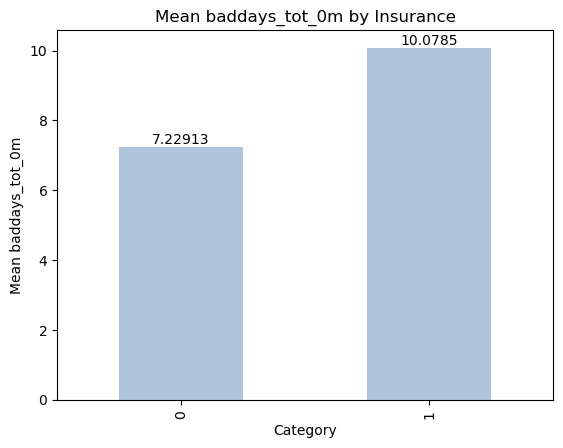

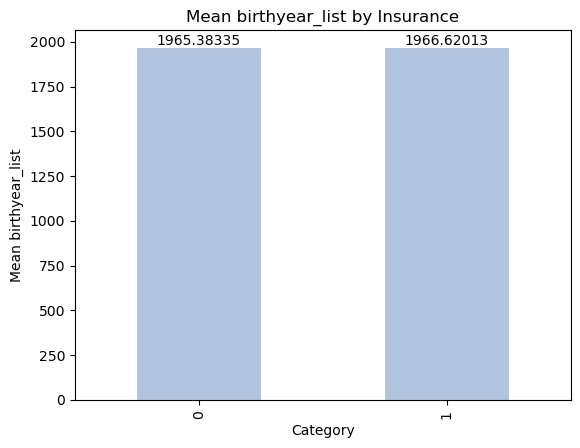

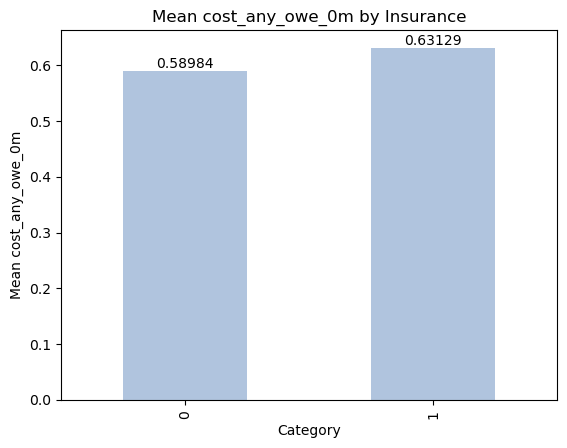

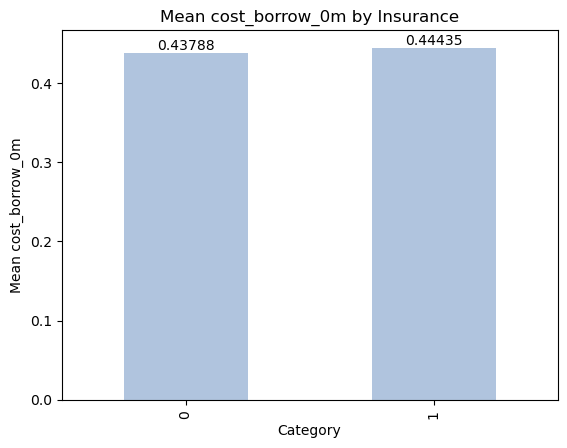

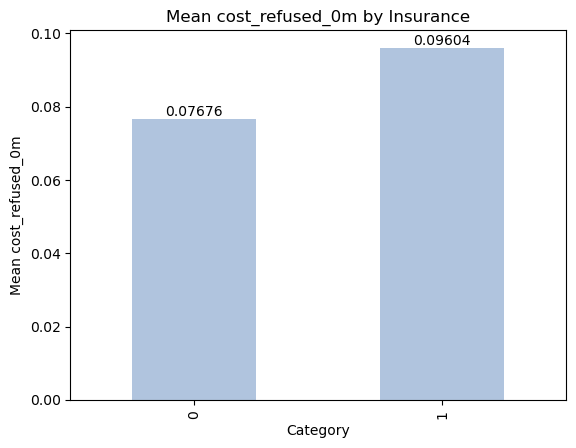

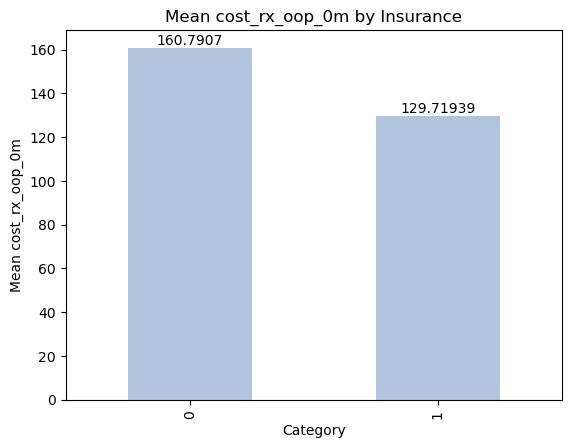

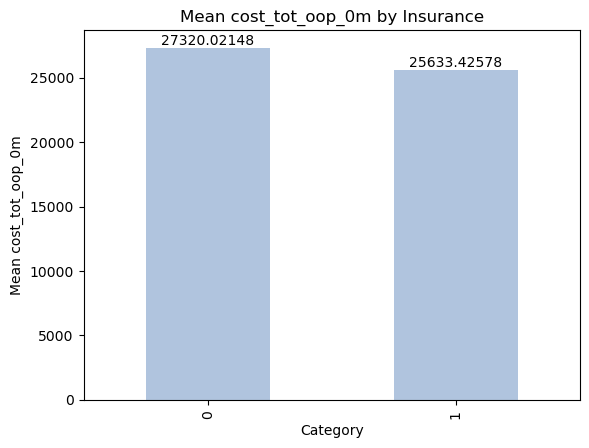

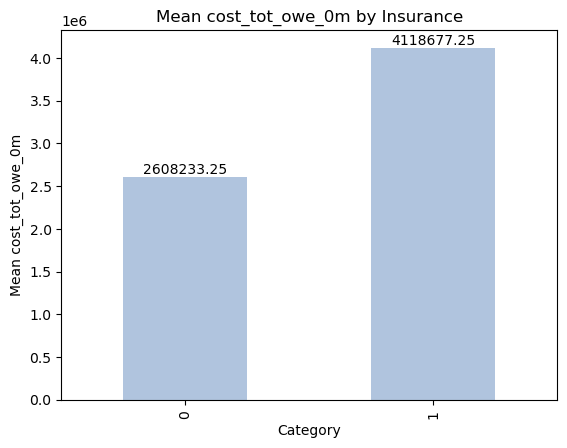

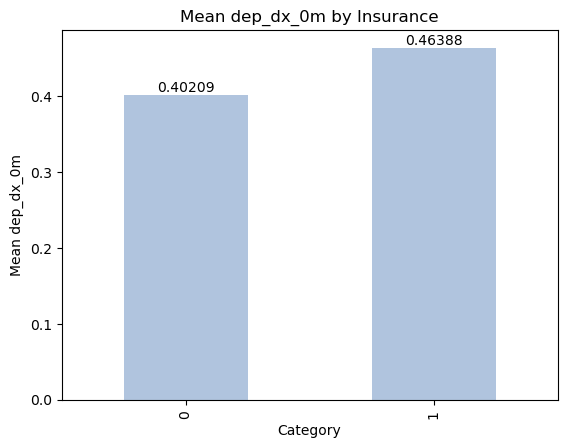

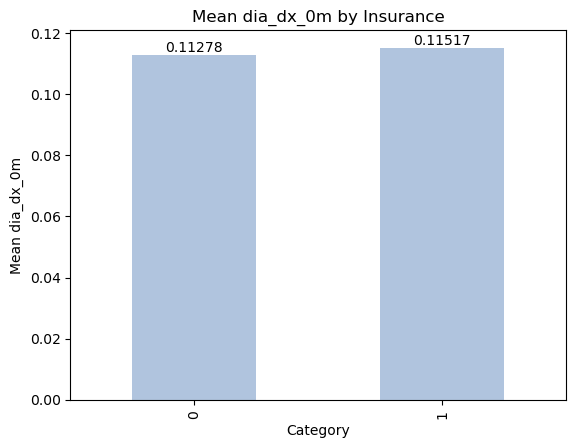

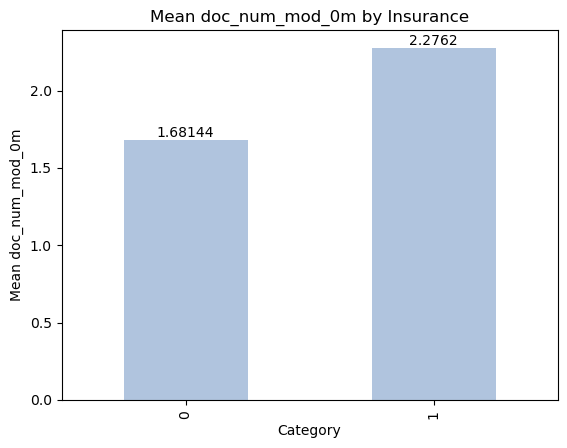

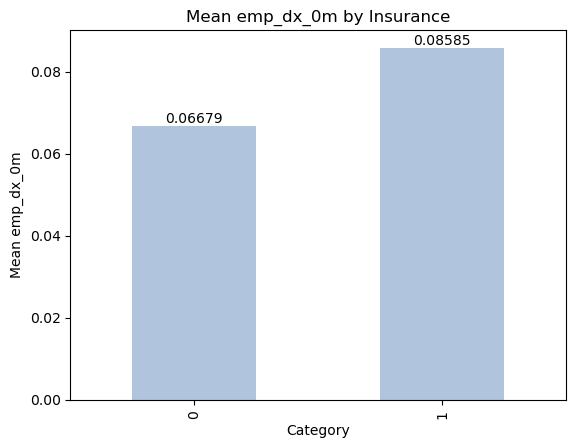

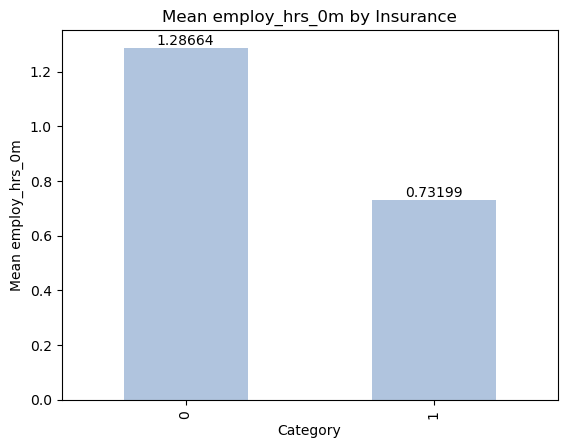

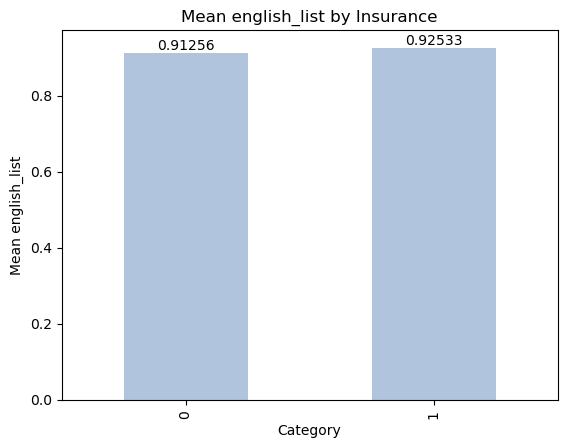

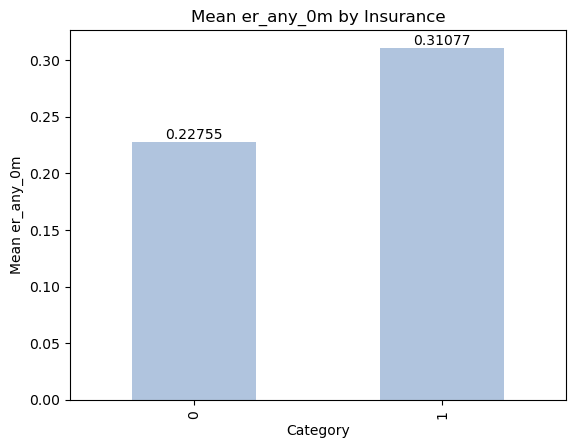

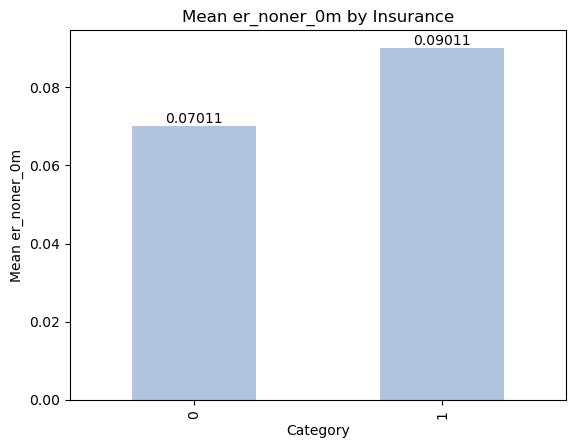

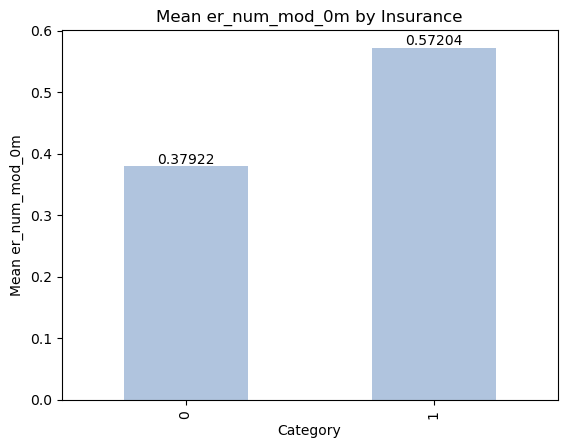

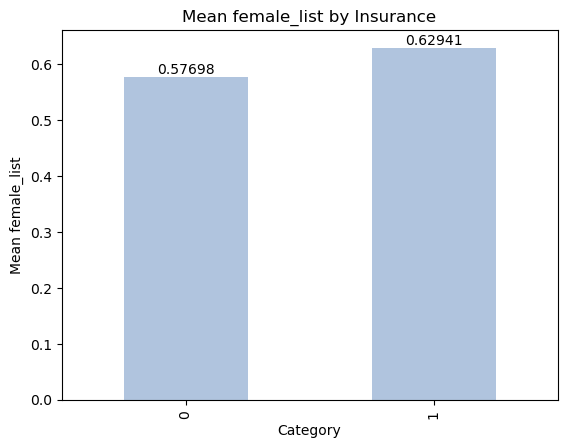

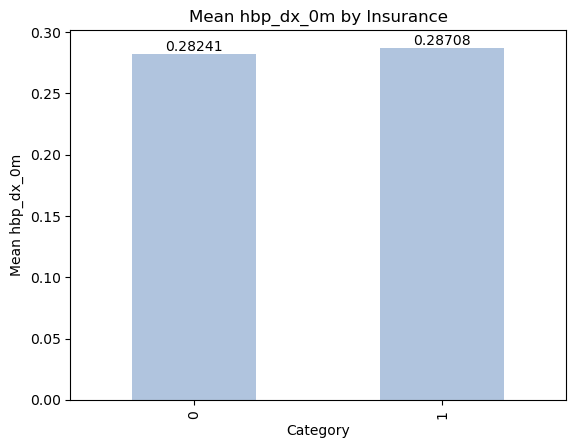

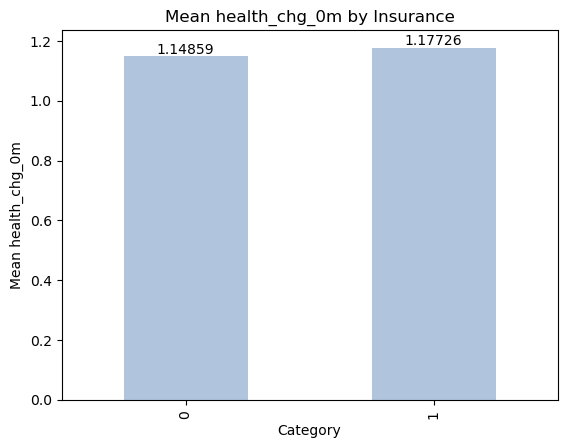

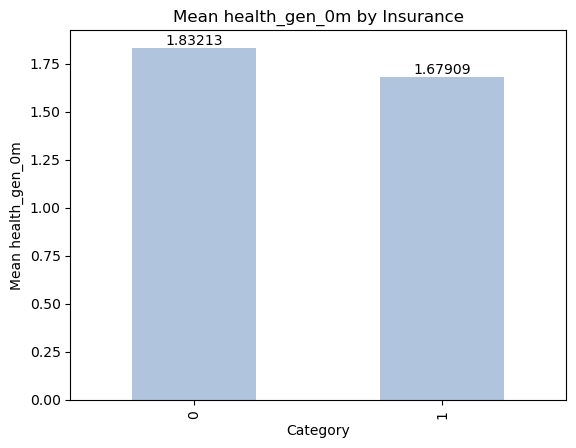

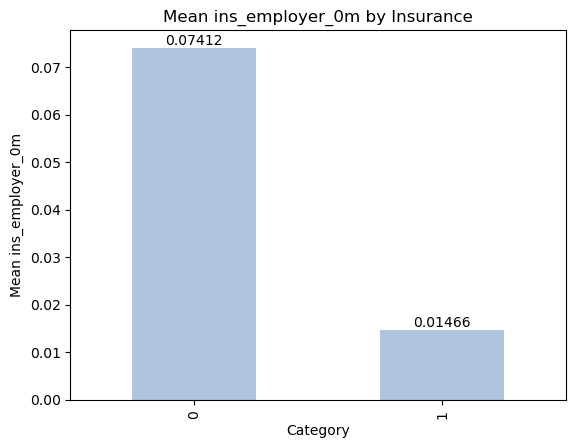

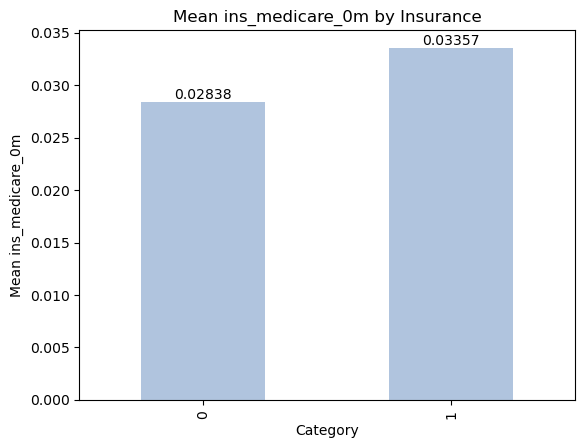

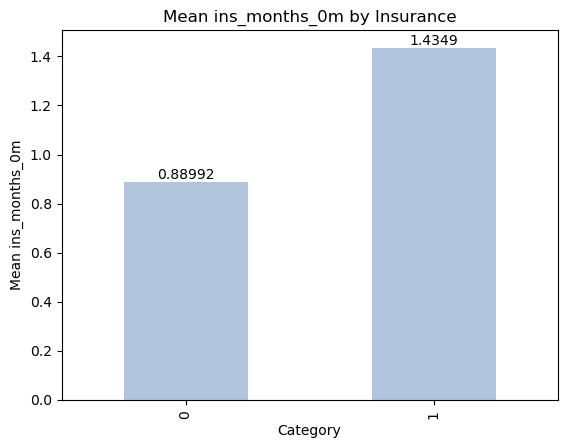

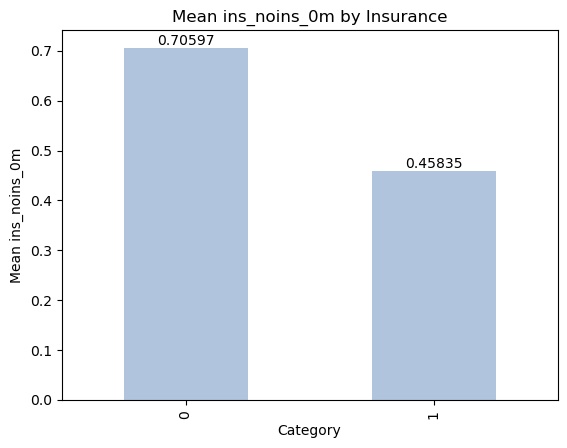

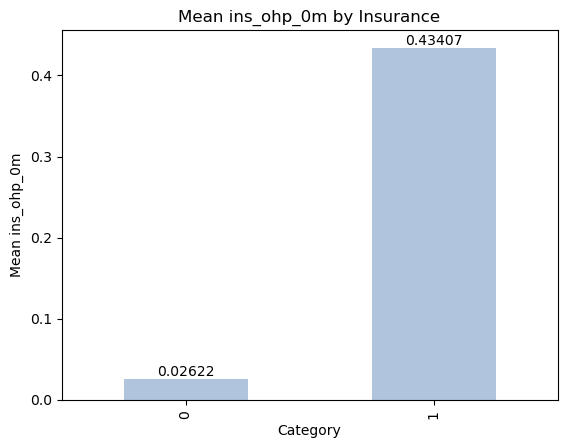

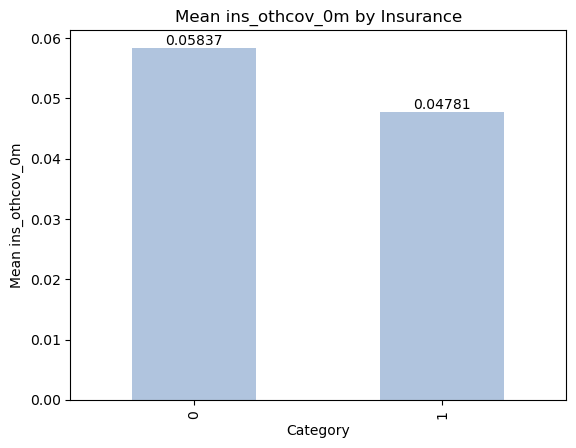

In [308]:
# Shows the imbalance in the data between control and treatment for first 5 covariates

trial = df_data.groupby('ohp_all_ever_matchn_30sep2009')[top_feat].agg('mean')

for name in top_feat[:30]:
    trial[name].plot(kind='bar', color='lightsteelblue')
    plt.xlabel('Category')
    plt.ylabel(f'Mean {name}')
    plt.title(f'Mean {name} by Insurance')
    for i, value in enumerate(trial[name]):
        plt.text(i, value, str(round(value,5)), ha='center', va='bottom')
    plt.show()

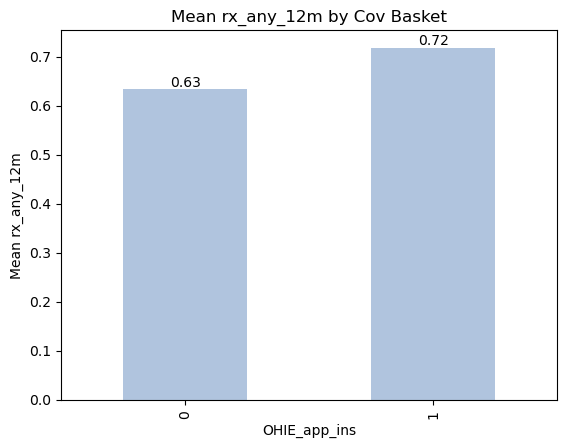

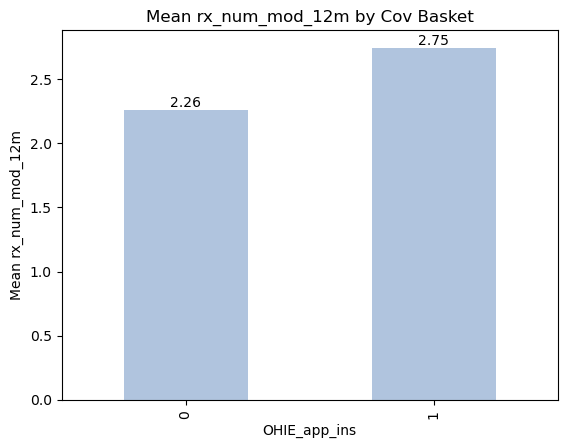

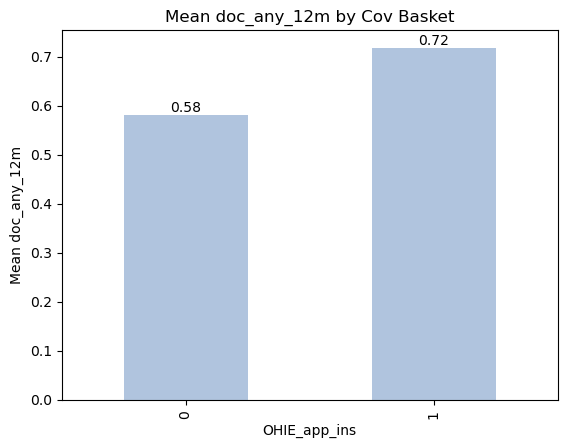

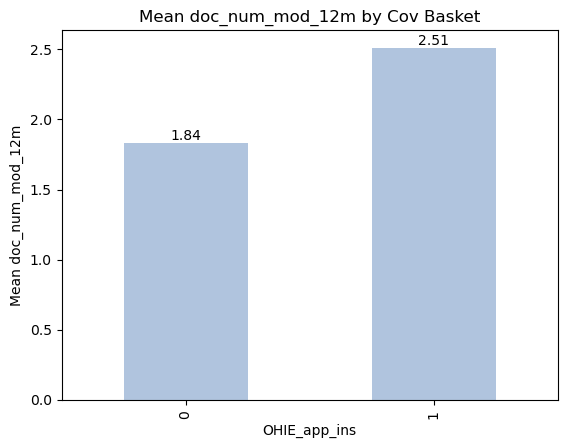

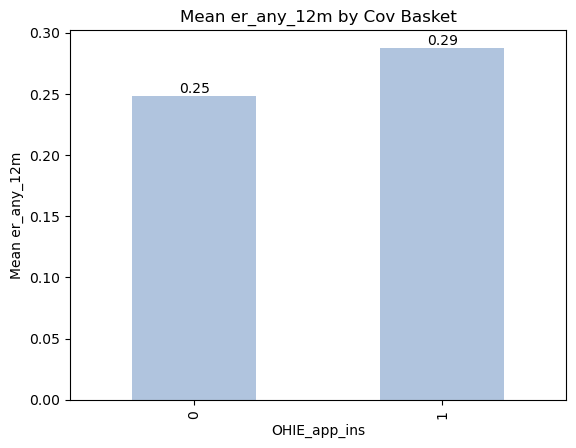

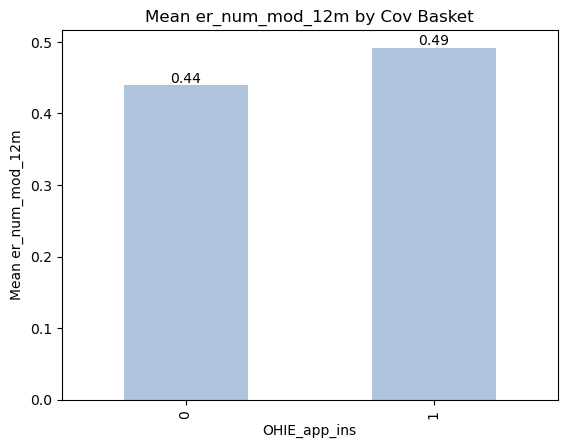

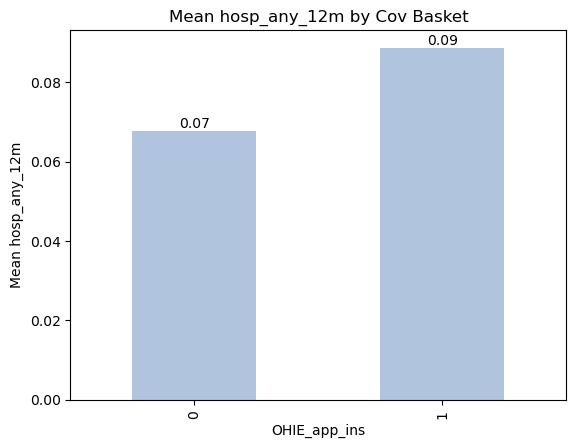

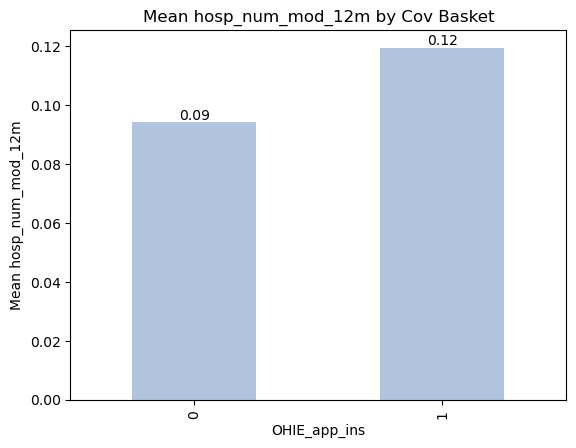

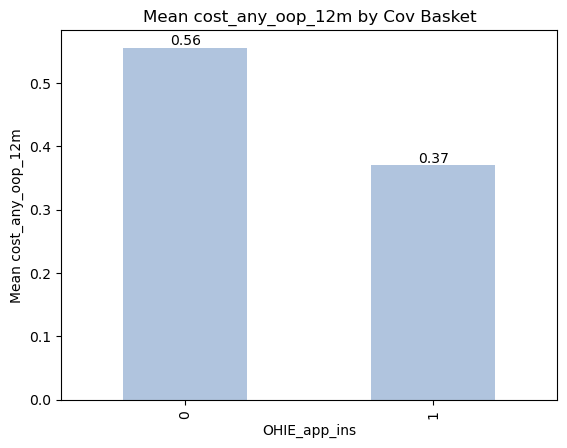

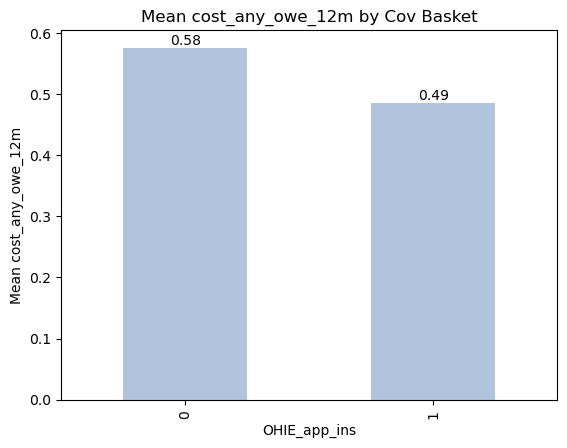

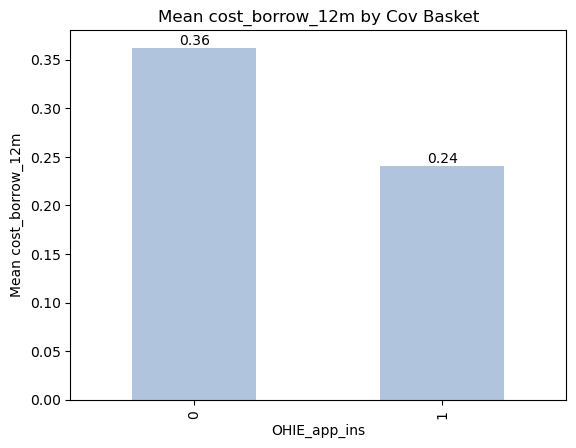

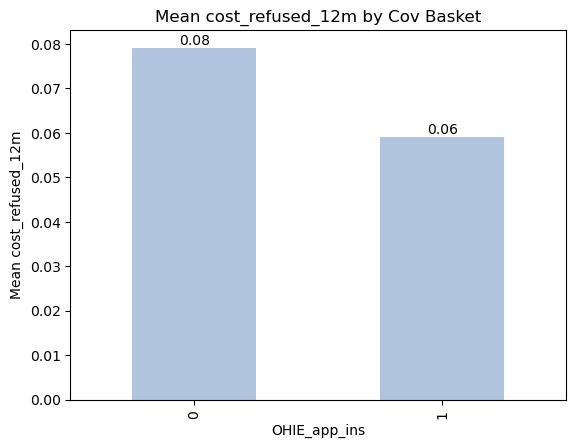

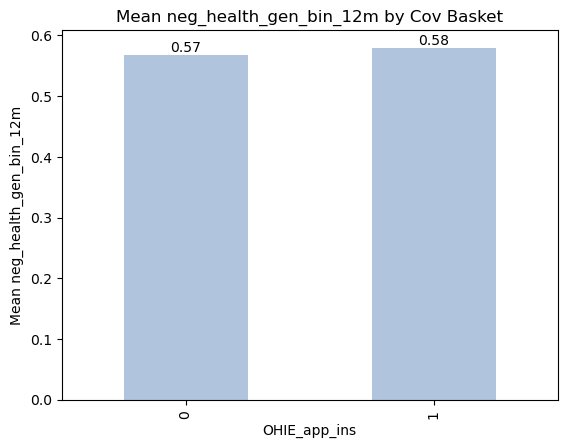

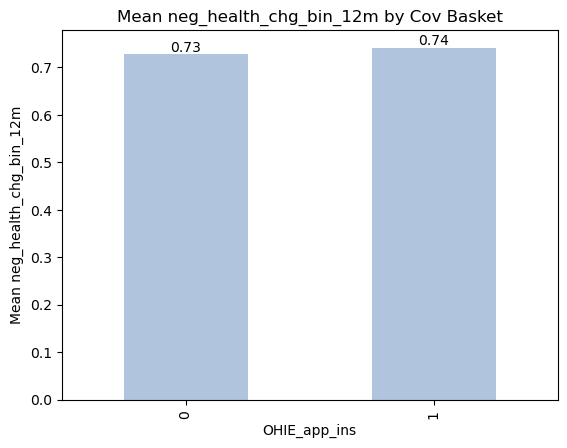

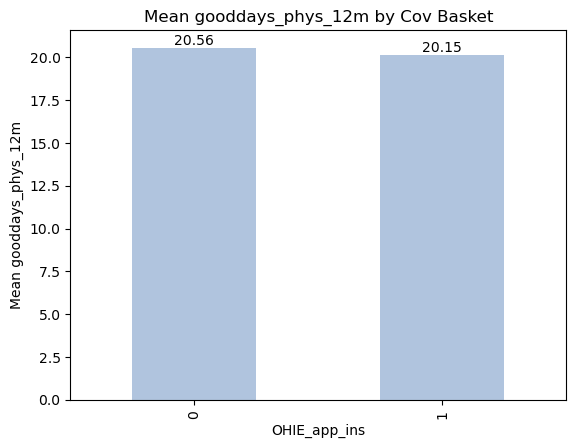

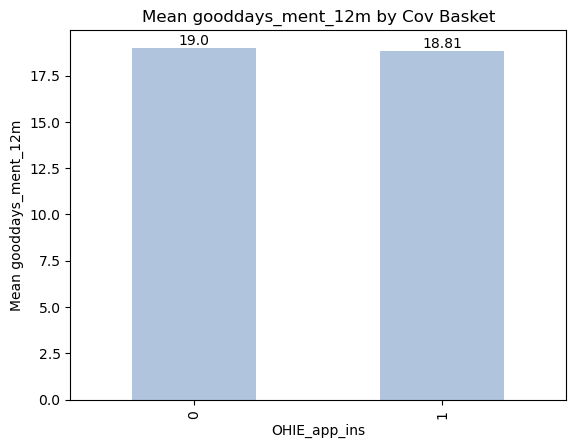

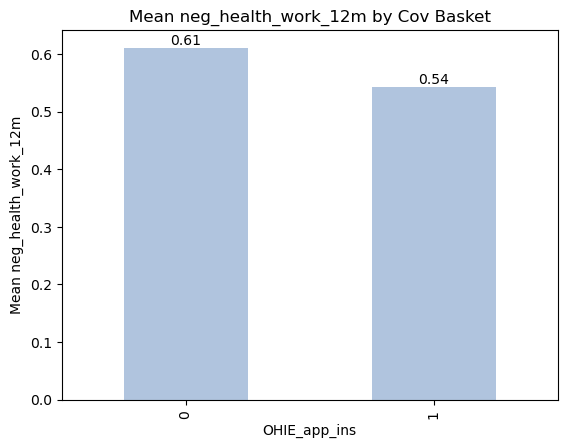

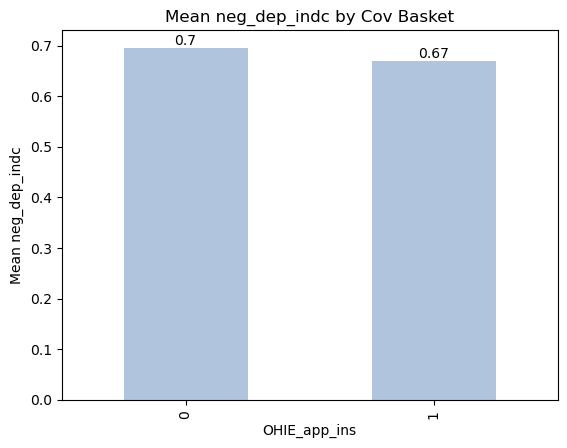

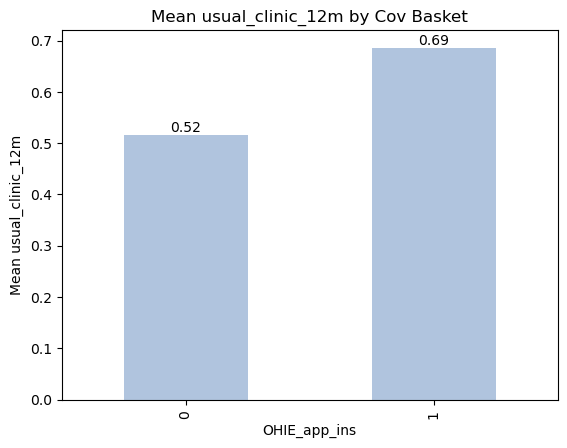

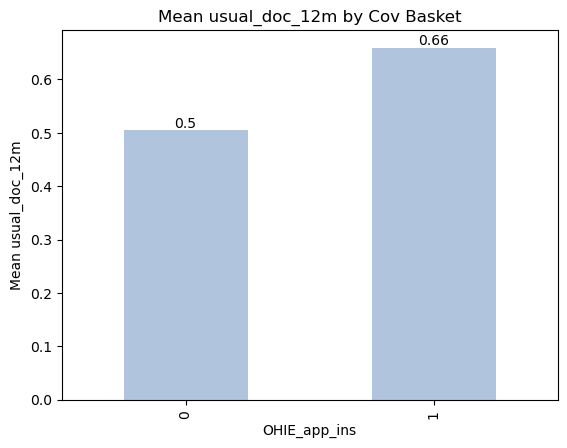

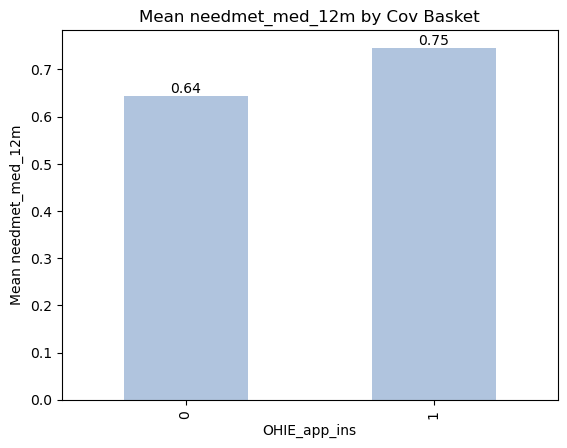

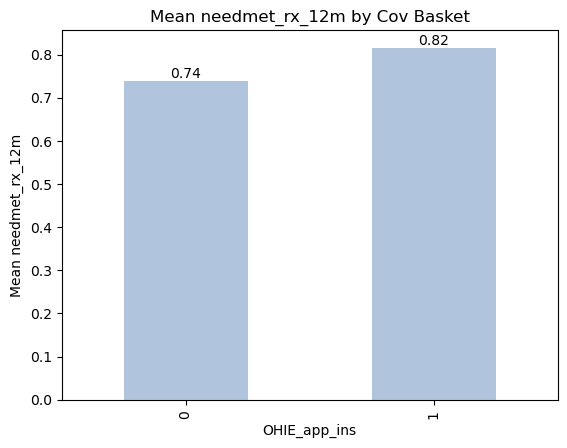

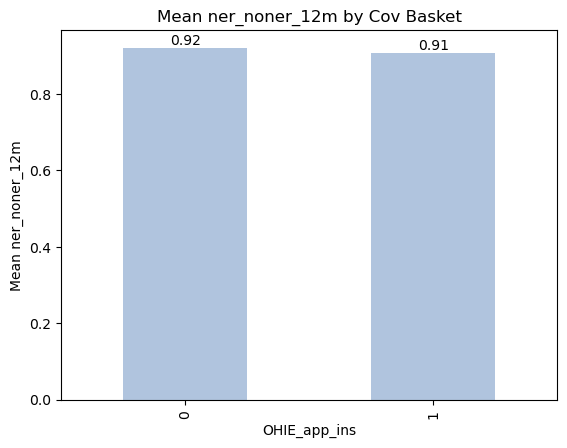

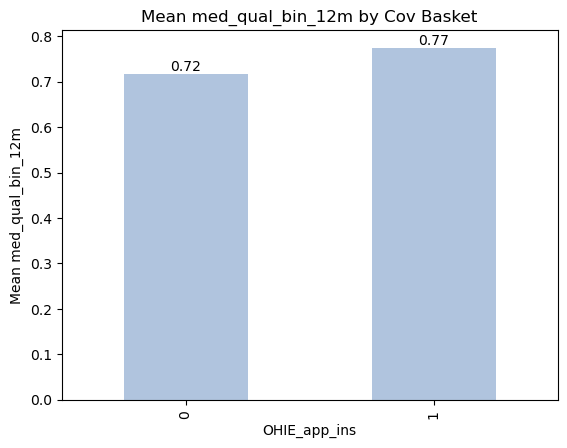

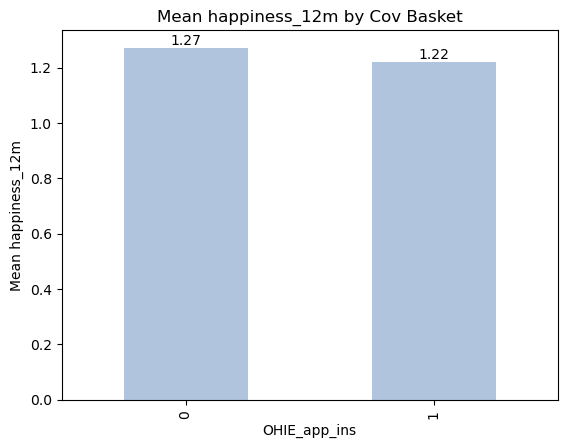

In [229]:
# some HTE stuff
# enter features of interest here
feat_of_inst = top_feat[0]

hte = df_data.groupby(feat_of_inst)
hte = hte[outcomes].agg('mean')

for name in outcomes:
    ax = hte[name].plot(kind = 'bar', color='lightsteelblue')
    plt.ylabel(f'Mean {name}')
    plt.title(f'Mean {name} by Cov Basket')
    for i, value in enumerate(hte[name]):
        plt.text(i, value, str(round(value,2)), ha='center', va='bottom')
    plt.show()



In [230]:
# KNN imputer
imputer = KNNImputer(n_neighbors=5)
imputed_sample = imputer.fit_transform(df_data)

## Checking the imputation propensity weighting the outcomes

In [233]:
# df_imputed_copy = df_imputed.copy()

In [399]:
df_imputed = df_imputed_copy

In [232]:
df_imputed = pd.DataFrame(imputed_sample)
df_imputed.columns = df_data.columns
df_imputed.describe()

,person_id,household_id,ohp_all_ever_matchn_30sep2009,rx_any_12m,rx_num_mod_12m,doc_any_12m,doc_num_mod_12m,er_any_12m,er_num_mod_12m,hosp_any_12m,...,rx_any_0m,rx_num_mod_0m,self_list,snap_ever_prenotify07,snap_ever_presurvey12m,snap_tot_hh_presurvey12m,tanf_ever_presurvey12m,treatment,usual_clinic_0m,usual_place_0m
count,23777.000000,23777.000000,23777.000000,23777.000000,23777.000000,23777.000000,23777.000000,23777.000000,23777.000000,23777.000000,...,23777.000000,23777.000000,23777.000000,23777.000000,23777.000000,23777.000000,23777.000000,23777.000000,23777.000000,23777.000000
mean,37302.768642,140996.813685,0.276570,0.644539,2.327249,0.604038,1.949472,0.254860,0.448871,0.071304,...,0.494343,1.676452,0.857804,0.576397,0.549775,1121.037095,0.008706,0.496741,0.474534,0.642495
std,21614.014102,21298.174726,0.447311,0.433564,2.599125,0.487088,2.912775,0.434183,0.988038,0.256683,...,0.424227,2.160850,0.349259,0.494139,0.497527,1539.095454,0.092900,0.500000,0.424250,0.414907
min,1.000000,100001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18532.000000,123328.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000
50%,37243.000000,142890.000000,0.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.400000,1.000000,1.000000,1.000000,1.000000,324.000000,0.000000,0.000000,0.400000,0.800000
75%,56007.000000,159414.000000,1.000000,1.000000,3.200000,1.000000,3.000000,1.000000,1.000000,0.000000,...,1.000000,2.400000,1.000000,1.000000,1.000000,1985.000000,0.000000,1.000000,1.000000,1.000000
max,74921.000000,174921.000000,1.000000,1.000000,24.000000,1.000000,30.000000,1.000000,10.000000,1.000000,...,1.000000,23.000000,1.000000,1.000000,1.000000,15190.000000,1.000000,1.000000,1.000000,1.000000


## Causal Forest

#### NA Values

In [309]:
# df_imputed = df_imputed_copy

#### Imputed Data 

## Outcome 1

In [401]:
Y1 = df_imputed[outcome1]
T = df_imputed['ohp_all_ever_matchn_30sep2009'] 
X1 = df_imputed[top_feat]

In [402]:
est1 = CausalForestDML(model_y=RandomForestRegressor(random_state=0),
                       model_t=RandomForestClassifier(random_state=0),
                       criterion='het', 
                       n_estimators=1000,
                       min_impurity_decrease=0.001, 
                       cv = 5, 
                       inference = True,
                       discrete_outcome=False,
                       discrete_treatment= True,
                       random_state=0)

est1.fit(Y1, T,X= X1)

In [403]:
hte1 = est1.effect(X1)
hte1_ci = est1.effect_interval(X1)

In [ ]:
hte1_df = pd.DataFrame(hte1)
treatment_df = pd.DataFrame(T, columns=['treatment'])

# Combine the treatment effects with the treatment indicator
combined_df = pd.concat([hte1_df, treatment_df], axis=1)

# Number of outcomes
num_outcomes = hte1_df.shape[1]

# Create subplots
fig, axes = plt.subplots(num_outcomes, 1, figsize=(10, num_outcomes * 5))

# Loop through each outcome and create box plots for each treatment group
for i in range(num_outcomes):
    # Split the data by treatment value
    treated_data = hte1_df.iloc[list(T == 1),i]
    control_data = hte1_df.iloc[list(T == 0),i]
    
    # Create box plots
    axes[i].boxplot([control_data, treated_data], labels=['Control', 'Treated'])
    axes[i].set_title(f'Treatment Effect for Outcome {outcome1[i]}')
    axes[i].set_ylabel('Effect Size')
    axes[i].set_xlabel('Treatment Group')

plt.tight_layout()
plt.show()



In [ ]:
ate1 = est1.ate_

In [ ]:
ate1_ci = est1.ate_interval(X1)

In [ ]:
ate_estimates = ate1

a, b = ate1_ci

confidence_intervals  = [[a, b] for a, b in zip(list_a, list_b)]

# Plotting
fig, ax = plt.subplots()
ax.errorbar(outcomes, ate_estimates.flatten(), yerr=np.abs(confidence_intervals.T - ate_estimates.flatten()), fmt='o')
ax.set_xticks(outcomes)
ax.set_xticklabels([f'{outcome}' for i, outcome in enumerate(outcome1)], rotation=90)
ax.set_title('ATE Estimates with Confidence Intervals')
ax.set_xlabel('Outcomes 1')
ax.set_ylabel('ATE Estimate')
plt.show()


## Outcome 2

In [404]:
Y2 = df_imputed[outcome2]

In [405]:
est2 = CausalForestDML(model_y=RandomForestRegressor(random_state=0),
                       model_t=RandomForestClassifier(random_state=0),
                       criterion='het', 
                       n_estimators=1000,
                       min_impurity_decrease=0.001, 
                       cv = 5, 
                       inference = True,
                       discrete_outcome=False,
                       discrete_treatment= True,
                       random_state=0)

est2.fit(Y2, T,X= X1)

In [406]:
hte2 = est2.effect(X1)
hte2_ci = est2.effect_interval(X1)

## Outcome 3

In [407]:
Y3 = df_imputed[outcome3]

In [ ]:
est3 = CausalForestDML(model_y=RandomForestRegressor(random_state=0),
                       model_t=RandomForestClassifier(random_state=0),
                       criterion='het', 
                       n_estimators=1000,
                       min_impurity_decrease=0.001, 
                       cv = 5, 
                       inference = True,
                       discrete_outcome=False,
                       discrete_treatment= True,
                       random_state=0)

est3.fit(Y3, T,X= X1)

In [ ]:
hte3 = est3.effect(X1)
hte3_ci = est3.effect_interval(X1)

## Outcome 4

In [ ]:
Y4 = df_imputed[outcome4]

In [ ]:
est4 = CausalForestDML(model_y=RandomForestRegressor(random_state=0),
                       model_t=RandomForestClassifier(random_state=0),
                       criterion='het', 
                       n_estimators=1000,
                       min_impurity_decrease=0.001, 
                       cv = 5, 
                       inference = True,
                       discrete_outcome=False,
                       discrete_treatment= True,
                       random_state=0)

est4.fit(Y4, T,X= X1)

In [ ]:
hte4 = est4.effect(X1)
hte4_ci = est4.effect_interval(X1)